# Baseline feature transformation

The simulated dataset generated in the previous section is simple. It only contains the essential features that characterize a payment card transaction. These are: a unique identifier for the transaction, the date and time of the transaction, the transaction amount, a unique identifier for the customer, a unique number for the merchant, and a binary variable that labels the transaction as legitimate or fraudulent (0 for legitimate or 1 for fraudulent)In this section we create new features from the already available ones, in order to extrapolate useful information for our analysis
</p>

In this section, we will implement three types of feature transformation that are known to be relevant for payment card fraud detection:

1) Binary encoding or One-Hot encoding <br>
2)Recency, Frequency, Monetary value <br>
3)Frequency encoding or risk encoding <br>

The first type of transformation involves the date/time variable, and consists in creating binary features that characterize potentially relevant periods. We will create two such features. The first one will characterize whether a transaction occurs during a weekday or during the weekend. The second will characterize whether a transaction occurs during the day or the night. These features can be useful since it has been observed that fraudulent patterns differ between weekdays and weekends, and between the day and night.  

The second type of transformation involves the customer ID and consists in creating features that characterize the customer spending behaviors. We will follow the RFM (Recency, Frequency, Monetary value) framework proposed in {cite}`VANVLASSELAER201538`, and keep track of the average spending amount and number of transactions for each customer and for three window sizes. This will lead to the creation of six new features.

The third type of transformation involves the terminal ID and consists in creating new features that characterize the 'risk' associated to the terminal. The risk will be defined as the average number of frauds that were observed on the terminal for three window sizes. This will lead to the creation of three new features. 

The table below summarizes the types of transformation that will be performed and the new features that will be created. 

|Original feature name|Original feature type|Transformation|Number of new features|New feature(s) type|
|---|---|---|---|---|
|TX\_DATE\_TIME | Panda timestamp |0 if transaction during a weekday, 1 if transaction during a weekend. The new feature is called TX_DURING_WEEKEND.|1|Integer (0/1)|
|TX\_DATE\_TIME | Panda timestamp |0 if transaction between 6am and 0pm, 1 if transaction between 0pm and 6am. The new feature is called TX_DURING_NIGHT.|1|Integer (0/1)|
|CUSTOMER\_ID | Categorical variable |Number of transactions by the customer in the last n day(s), for n in {1,7,30}. The new features are called CUSTOMER_ID_NB_TX_nDAY_WINDOW.|3|Integer|
|CUSTOMER\_ID | Categorical variable |Average spending amount in the last n day(s), for n in {1,7,30}. The new features are called CUSTOMER_ID_AVG_AMOUNT_nDAY_WINDOW.|3|Real|
|TERMINAL\_ID | Categorical variable |Number of transactions on the terminal in the last n+d day(s), for n in {1,7,30} and d=7. The parameter d is called delay and will be discussed later in this notebook. The new features are called TERMINAL_ID_NB_TX_nDAY_WINDOW.|3|Integer|
|TERMINAL\_ID | Categorical variable |Average number of frauds on the terminal in the last n+d day(s), for n in {1,7,30} and d=7. The parameter d is called delay and will be discussed later in this notebook. The new features are called TERMINAL_ID_RISK_nDAY_WINDOW.|3|Real|

The following sections provide the implementation for each of these three transformations. After the transformations, a set of 14 new features will be created. Note that some of the features are the result of aggregation functions over the values of other features or conditions (same customer, given time window). These features are often referred to as *aggregated features*.


## Loading of dataset

Let us first load the transaction data simulated in the previous notebook. 
The function takes as input the folder where the data files are located, and the dates that define the period to load (between `BEGIN_DATE` and `END_DATE`). It returns a DataFrame of transactions. The transactions are sorted by chronological order. 

In [ ]:
#mounting google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
!curl -O https://github.com/leonardoimperit/thesis-timperi/shared_functions_imports.py
%run shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31568  100 31568    0     0   138k      0 --:--:-- --:--:-- --:--:--  138k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     9  100     9    0     0     62      0 --:--:-- --:--:-- --:--:--    62


In [ ]:
# Load a set of pickle files, put them together in a single DataFrame, and order them by time
# It takes as input the folder DIR_INPUT where the files are stored, and the BEGIN_DATE and END_DATE
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

In [ ]:
DIR_INPUT='/content/drive/MyDrive/Colab Notebooks/tesi/ready for repository/simulated_data/' 

BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


Load  files
CPU times: user 2.85 s, sys: 297 ms, total: 3.15 s
Wall time: 1min 40s
1754155 transactions loaded, containing 14681 fraudulent transactions


In [1]:
transactions_df.head()

NameError: ignored

## Date and time transformations

We will create two new binary features from the transaction dates and times:

* The first will characterize whether a transaction occurs during a weekday (value 0) or a weekend (1), and will be called `TX_DURING_WEEKEND`
* The second will characterize whether a transaction occurs during the day or during the day (0) or during the night (1). The night is defined as hours that are between 0pm and 6am. It will be called `TX_DURING_NIGHT`. 

For the `TX_DURING_WEEKEND` feature, we define a function `is_weekend` that takes as input a Panda timestamp, and returns 1 if the date is during a weekend, or 0 otherwise. The timestamp object conveniently provides the `weekday` function to help in computing this value.

In [ ]:
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

In [ ]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

CPU times: user 7.1 s, sys: 70.6 ms, total: 7.17 s
Wall time: 7.18 s


We follow the same logic to implement the `TX_DURING_NIGHT` feature. First, a function `is_night` that takes as input a Panda timestamp, and returns 1 if the time is during the night, or 0 otherwise. The timestamp object conveniently provides the hour property to help in computing this value.

In [ ]:
def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

In [ ]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

CPU times: user 7.15 s, sys: 88.1 ms, total: 7.24 s
Wall time: 7.24 s


Let us check that these features where correctly computed.

In [ ]:
transactions_df[transactions_df.TX_TIME_DAYS>=30]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT
288062,288062,2018-05-01 00:01:21,3546,2944,18.71,2592081,30,0,0,0,1
288063,288063,2018-05-01 00:01:48,206,3521,18.60,2592108,30,0,0,0,1
288064,288064,2018-05-01 00:02:22,2610,4470,66.67,2592142,30,0,0,0,1
288065,288065,2018-05-01 00:03:15,4578,1520,79.41,2592195,30,0,0,0,1
288066,288066,2018-05-01 00:03:51,1246,7809,52.08,2592231,30,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,1,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,1,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0,1,0


## Customer ID transformations

Let us now proceed with customer ID transformations. We will take inspiration from the RFM (Recency, Frequency, Monetary value) framework , and compute two of these features over three time windows. The first feature will be the number of transactions that occur within a time window (Frequency). The second will be the average amount spent in these transactions (Monetary value). The time windows will be set to one, seven, and thirty days. This will generate six new features. Note that these time windows could later be optimized along with the models using a model selection procedure ([Chapter 5](Model_Selection)). 

Let us implement these transformations by writing a `get_customer_spending_behaviour_features` function. The function takes as inputs the set of transactions for a customer and a set of window sizes. It returns a DataFrame with the six new features. Our implementation relies on the Panda `rolling` function, which makes easy the computation of aggregates over a time window.


In [ ]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions


Let us compute these aggregates for the first customer.

In [ ]:
spending_behaviour_customer_0=get_customer_spending_behaviour_features(transactions_df[transactions_df.CUSTOMER_ID==0])
spending_behaviour_customer_0

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,
1758,1758,2018-04-01 07:19:05,0,6076,123.59,26345,0,0,0,1,0,1.0,123.590000,1.0,123.590000,1.0,123.590000
8275,8275,2018-04-01 18:00:16,0,858,77.34,64816,0,0,0,1,0,2.0,100.465000,2.0,100.465000,2.0,100.465000
8640,8640,2018-04-01 19:02:02,0,6698,46.51,68522,0,0,0,1,0,3.0,82.480000,3.0,82.480000,3.0,82.480000
12169,12169,2018-04-02 08:51:06,0,6569,54.72,118266,1,0,0,0,0,3.0,59.523333,4.0,75.540000,4.0,75.540000
15764,15764,2018-04-02 14:05:38,0,7707,63.30,137138,1,0,0,0,0,4.0,60.467500,5.0,73.092000,5.0,73.092000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750390,1750390,2018-09-30 13:38:41,0,3096,38.23,15773921,182,0,0,1,0,5.0,64.388000,28.0,57.306429,89.0,63.097640
1750758,1750758,2018-09-30 14:10:21,0,9441,43.60,15775821,182,0,0,1,0,6.0,60.923333,29.0,56.833793,89.0,62.433933
1751039,1751039,2018-09-30 14:34:30,0,1138,69.69,15777270,182,0,0,1,0,7.0,62.175714,29.0,57.872414,90.0,62.514556


Let us now generate these features for all customers. This is straightforward using the Panda `groupby` and `apply` methods.

In [ ]:
%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: user 41.9 s, sys: 366 ms, total: 42.3 s
Wall time: 42.1 s


In [ ]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,1,1.0,57.160000,1.0,57.160000,1.0,57.160000
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,1,1.0,81.510000,1.0,81.510000,1.0,81.510000
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,1,1.0,146.000000,1.0,146.000000,1.0,146.000000
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,1,1.0,64.490000,1.0,64.490000,1.0,64.490000
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,1,1.0,50.990000,1.0,50.990000,1.0,50.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,1,0,2.0,75.280000,12.0,67.047500,72.0,69.521111
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1,0,1.0,1.230000,21.0,22.173810,93.0,24.780753
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,1,0,5.0,7.368000,21.0,7.400476,65.0,7.864462
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0,1,0,3.0,100.696667,16.0,107.052500,51.0,102.919608


## Terminal ID transformations

Finally, let us proceed with the terminal ID transformations. The main goal will be to extract a risk score, that assesses the exposure of a given terminal ID to fraudulent transactions. The risk score will be defined as the average number of fraudulent transactions that occurred on a terminal ID over a time window. As for customer ID transformations, we will use three window sizes, of 1, 7, and 30 days.

Contrary to customer ID transformations, the time windows will not directly precede a given transaction. Instead, they will be shifted back by a delay period. The delay period accounts for the fact that, in practice, the fraudulent transactions are only discovered after a fraud investigation or a customer complaint. Hence, the fraudulent labels, which are needed to compute the risk score, are only available after this delay period. To a first approximation, this delay period will be set to one week. 

Let us perform the computation of the risk scores by defining a get_count_risk_rolling_window function. The function takes as inputs the DataFrame of transactions for a given terminal ID, the delay period, and a list of window sizes. In the first stage, the number of transactions and fraudulent transactions are computed for the delay period (NB_TX_DELAY and NB_FRAUD_DELAY). In the second stage, the number of transactions and fraudulent transactions are computed for each window size plus the delay period (NB_TX_DELAY_WINDOW and NB_FRAUD_DELAY_WINDOW). The number of transactions and fraudulent transactions that occurred for a given window size, shifted back by the delay period, is then obtained by simply computing the differences of the quantities obtained for the delay period, and the window size plus delay period:

NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY

The risk score is finally obtained by computing the proportion of fraudulent transactions for each window size (or 0 if no transaction occurred for the given window):

RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW

Additionally to the risk score, the function also returns the number of transactions for each window size. This results in the addition of six new features: The risk and number of transactions, for three window sizes.


In [ ]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions


Let us compute these six features for the first terminal ID containing at least one fraud:

In [ ]:
# Get the first terminal ID that contains frauds
np.array(transactions_df[transactions_df.TX_FRAUD==1].TERMINAL_ID)[0]

3059

In [ ]:
get_count_risk_rolling_window(transactions_df[transactions_df.TERMINAL_ID==3059], delay_period=7, windows_size_in_days=[1,7,30]).head(8)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,,,,
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1,1,0,3.0,158.073333,3.0,158.073333,3.0,158.073333,0.0,0.0,0.0,0.0,0.0,0.0
4732,4732,2018-04-01 11:59:14,55,3059,36.28,43154,0,0,0,1,0,2.0,35.670000,2.0,35.670000,2.0,35.670000,0.0,0.0,0.0,0.0,0.0,0.0
16216,16216,2018-04-02 14:47:34,4879,3059,105.00,139654,1,0,0,0,0,4.0,95.797500,10.0,76.010000,10.0,76.010000,0.0,0.0,0.0,0.0,0.0,0.0
18249,18249,2018-04-02 19:08:10,2263,3059,90.89,155290,1,0,0,0,0,3.0,60.006667,7.0,50.458571,7.0,50.458571,0.0,0.0,0.0,0.0,0.0,0.0
26512,26512,2018-04-03 15:44:49,4879,3059,58.51,229489,2,0,0,0,0,3.0,54.066667,14.0,71.070000,14.0,71.070000,0.0,0.0,0.0,0.0,0.0,0.0
29143,29143,2018-04-04 02:47:50,380,3059,14.86,269270,3,0,0,0,1,3.0,53.106667,10.0,47.571000,10.0,47.571000,0.0,0.0,0.0,0.0,0.0,0.0
31121,31121,2018-04-04 08:14:29,2508,3059,20.44,288869,3,0,0,0,0,4.0,32.107500,6.0,34.176667,6.0,34.176667,0.0,0.0,0.0,0.0,0.0,0.0
32815,32815,2018-04-04 10:49:58,1783,3059,13.04,298198,3,0,0,0,0,4.0,45.325000,14.0,81.404286,14.0,81.404286,0.0,0.0,0.0,0.0,0.0,0.0


We can check that the first fraud occurred on the 2018/04/01, and that risk scores only start being counted with a one-week delay. 

Let us finally generate these features for all terminals. This is straightforward using the Panda `groupby` and `apply` methods. 

In [ ]:
%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)


CPU times: user 1min 37s, sys: 742 ms, total: 1min 38s
Wall time: 1min 37s


In [ ]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,1,1.0,57.160000,1.0,57.160000,1.0,57.160000,0.0,0.0,0.0,0.0,0.0,0.00000
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,1,1.0,81.510000,1.0,81.510000,1.0,81.510000,0.0,0.0,0.0,0.0,0.0,0.00000
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,1,1.0,146.000000,1.0,146.000000,1.0,146.000000,0.0,0.0,0.0,0.0,0.0,0.00000
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,1,1.0,64.490000,1.0,64.490000,1.0,64.490000,0.0,0.0,0.0,0.0,0.0,0.00000
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,1,1.0,50.990000,1.0,50.990000,1.0,50.990000,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,1,0,2.0,75.280000,12.0,67.047500,72.0,69.521111,1.0,0.0,4.0,0.0,28.0,0.00000
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1,0,1.0,1.230000,21.0,22.173810,93.0,24.780753,1.0,0.0,9.0,0.0,39.0,0.00000
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,1,0,5.0,7.368000,21.0,7.400476,65.0,7.864462,1.0,0.0,5.0,0.0,33.0,0.00000
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0,1,0,3.0,100.696667,16.0,107.052500,51.0,102.919608,1.0,0.0,6.0,0.0,28.0,0.00000


# Data Analysis

This section is of fundamental importance, because here we will start to deeply analyze the behaviour of our features, their correlation and the presence of any anomalies. This is the starting point for the detection of outliers or other kind of noise  we want to deal with before proceding with our models

In [ ]:
#This function provides a preliminary analysis of our dataset.  
transactions_df.describe()

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
count,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06,1.754155e+06
mean,8.770770e+05,2.504011e+03,4.996733e+03,5.363230e+01,7.903234e+06,9.097260e+01,8.369272e-03,1.882388e-02,2.898176e-01,1.738552e-01,3.560578e+00,5.362741e+01,1.864045e+01,5.361508e+01,7.174940e+01,5.360278e+01,9.597419e-01,5.062488e-03,6.607971e+00,7.909228e-03,2.640982e+01,7.538655e-03
std,5.063811e+05,1.445987e+03,2.886101e+03,4.232649e+01,4.565172e+06,5.283709e+01,9.110012e-02,2.113263e-01,4.536777e-01,3.789850e-01,1.847658e+00,3.504634e+01,7.883447e+00,3.046794e+01,3.216790e+01,2.933973e+01,1.019762e+00,6.764030e-02,3.306587e+00,7.122464e-02,1.141545e+01,5.620902e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-7.105427e-15,1.000000e+00,2.000000e-02,1.000000e+00,2.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.385385e+05,1.252000e+03,2.502000e+03,2.101000e+01,3.940846e+06,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.571000e+01,1.300000e+01,2.824600e+01,4.700000e+01,2.867894e+01,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,2.100000e+01,0.000000e+00
50%,8.770770e+05,2.506000e+03,4.994000e+03,4.464000e+01,7.902670e+06,9.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,4.925333e+01,1.900000e+01,5.236450e+01,7.600000e+01,5.302643e+01,1.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,2.700000e+01,0.000000e+00
75%,1.315616e+06,3.765000e+03,7.495000e+03,7.695000e+01,1.186566e+07,1.370000e+02,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,5.000000e+00,7.600000e+01,2.400000e+01,7.688119e+01,9.800000e+01,7.760878e+01,2.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00,3.400000e+01,0.000000e+00
max,1.754154e+06,4.999000e+03,9.999000e+03,2.628000e+03,1.581120e+07,1.820000e+02,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01,1.377075e+03,5.200000e+01,5.092833e+02,1.570000e+02,2.910900e+02,1.000000e+01,1.000000e+00,2.800000e+01,1.000000e+00,8.200000e+01,1.000000e+00


In [ ]:
#the function info displays some important information about features  type.
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 23 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   TRANSACTION_ID                       int64         
 1   TX_DATETIME                          datetime64[ns]
 2   CUSTOMER_ID                          int64         
 3   TERMINAL_ID                          int64         
 4   TX_AMOUNT                            float64       
 5   TX_TIME_SECONDS                      int64         
 6   TX_TIME_DAYS                         int64         
 7   TX_FRAUD                             int64         
 8   TX_FRAUD_SCENARIO                    int64         
 9   TX_DURING_WEEKEND                    int64         
 10  TX_DURING_NIGHT                      int64         
 11  CUSTOMER_ID_NB_TX_1DAY_WINDOW        float64       
 12  CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW   float64       
 13  CUSTOMER_ID_NB_TX_7DAY_WIND

Here we have a first look to one of our main problems in classification: class imbalance. 

In [ ]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(transactions_df['TX_FRAUD'].value_counts()[0]/len(transactions_df) * 100,2), '% of the dataset')
print('Frauds', round(transactions_df['TX_FRAUD'].value_counts()[1]/len(transactions_df) * 100,2), '% of the dataset')

No Frauds 99.16 % of the dataset
Frauds 0.84 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

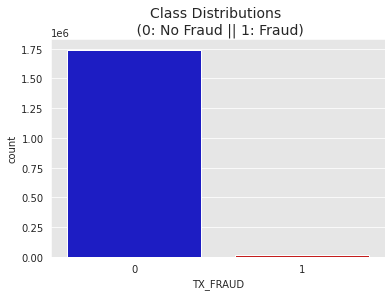

In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('TX_FRAUD', data=transactions_df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Here we  plot the distribution of transaction amounts and transaction times. To save some time here we display only the first 10 days.

In [ ]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

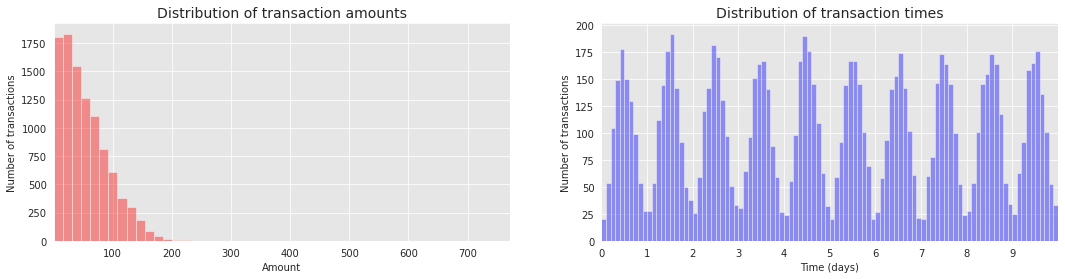

In [ ]:
distribution_amount_times_fig

The distribution of transaction amounts has most of its mass for small amounts. The distribution of transaction times  follows a gaussian distribution on a daily basis, centered around noon. These two distributions are in accordance with the simulation parameters used in the previous sections.  

We do the same here but in a considering the whole distribution.

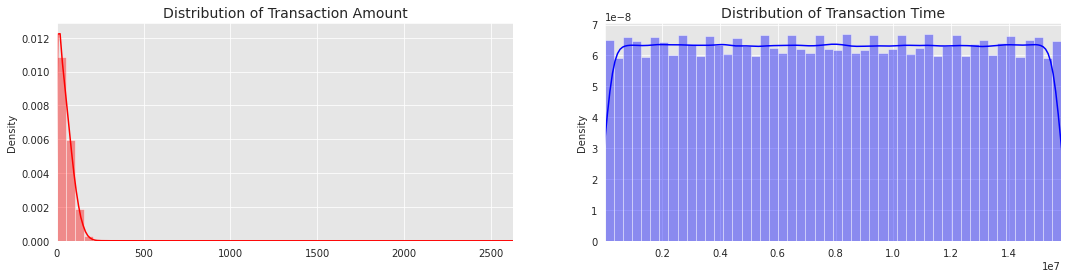

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df['TX_AMOUNT'].values
time_val = transactions_df['TX_TIME_SECONDS'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

As we will discuss in the "Real World Section", the distribution of Transaction Amount is comparable to the  distribution in a real-world scenario. However the distribution of transaction time shows different behaviour compared to the real world dataset. However it is worth pointing  out that our real world dataset refers to just 2 transaction days, whereas our simulated dataset covers 180 days.

Here we display the graph for each feature to understand their distribution

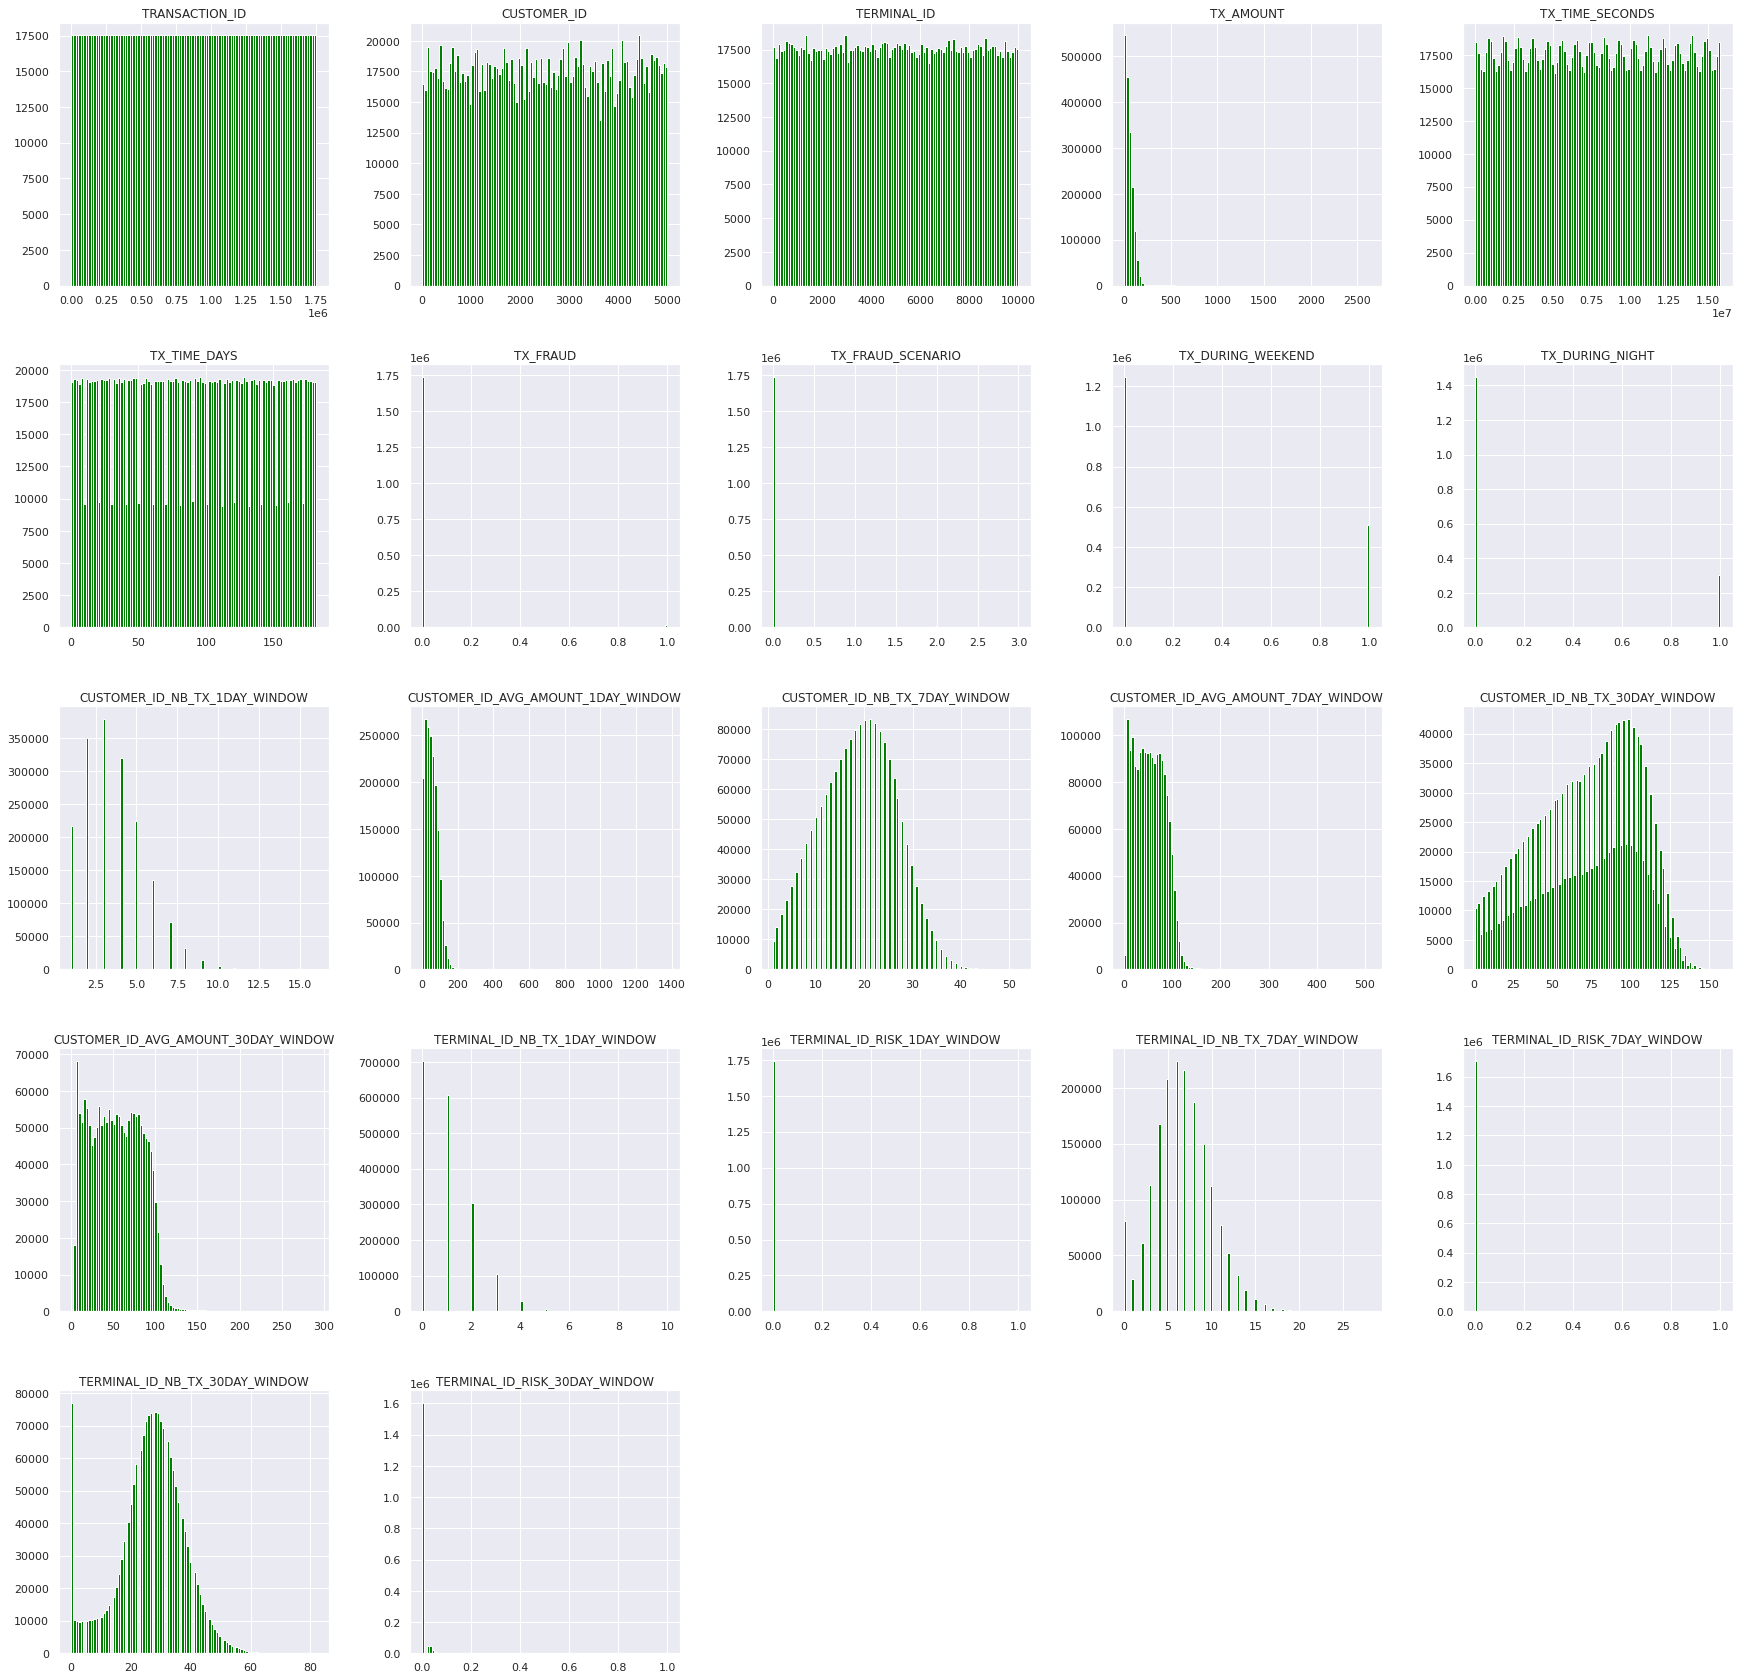

In [ ]:
%matplotlib inline  
sns.set()
transactions_df.hist(bins=100, figsize=(30, 30), color='green')
plt.show()

From these graphs we can first see that our features shows very different distributions depending on what they represent. It is interesting to see that monetary continuous variable (the ones referred to amount) show a symmetric behaviour around their mean. Variable like TX_NIGHT and TX_WEEKEND show a distribution linked to the natural frequency (of night and weekends respectivelu), revealing that our feature engineering process seems to be correct. Given the different of scale of most of our features, we can already understand that scaling will be fundamental for the well functioning of any non-tree classification model.

Let us check how the number of transactions, the number of fraudulent transactions, and the number of frauded cards vary on a daily basis. This is important to understand whether our simulator worked properly and to detect potential anomalies.

In [ ]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [ ]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of frauded cards per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)



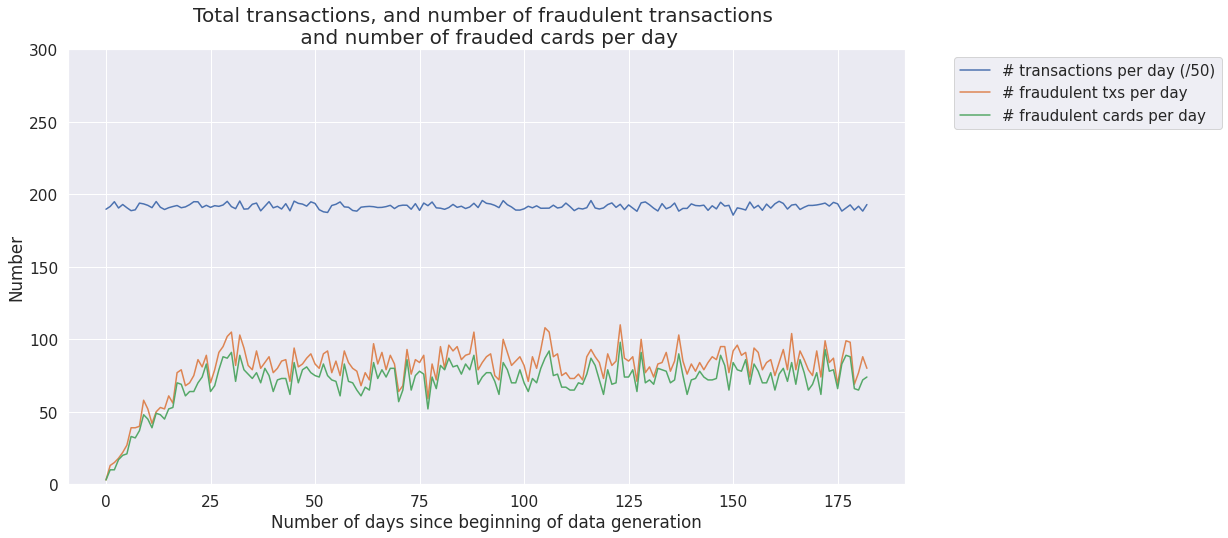

In [ ]:
fraud_and_transactions_stats_fig

This simulation generated around 10000 transactions per day. The number of fraudulent transactions per day  is around 85, and the number of fraudulent cards around 80. It is worth noting that the first month has a lower number of fraudulent transactions, which is due to the fact that frauds from scenarios 2 and 3 span periods of 28 and 14 days, respectively. 



# Boxplot analysis and data cleaning

We will cover and expand this section in a later time. This will go through each feature in order to detect any possible outliers. However, since we are dealing with simulated data, we don't expect to have significant anomalies (if the simulator worked properly). 

The Data scaling will be perfomed later as not all classification models require it

## Saving the transformed dataset

Let us finally save the transformed dataset, split into daily batches, using the pickle format. 

In [ ]:
DIR_OUTPUT = "/content/drive/MyDrive/Colab Notebooks/tesi/ready for repository/transformed_simulated data/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

# TRAIN AND TEST SET

Before concluding this section we will proceed in the construction of a train and a test set for our model. This will be of fundamental importance for the comparison of our different models, with and without oversampling, and without cross validation. For the cross validation we will need greater caution and we will face it later.

In this section we will define a training set (historical data) and a test set (new data). The training set is the subset of transactions that are used for training the prediction model. The test set is the subset of transactions that are used to assess the performance of the prediction model.

The training set aims at training a prediction model, while the test set aims at evaluating the performance of the prediction model on new data. In a fraud detection context, the transactions of the test set occur chronologically *after* the transactions used for training the model. 

We will use the transactions from the 2018-05-06 to the 2018-08-10" for the training set, and from the 2018-08-17 to the 2018-09-10 for the test set. 

It is worth noting that we choose our test set to take place one week after the last transaction of the training set. In a fraud detection context, this period separating the training and test set is referred to as the *delay period* or *feedback delay* {cite}`dal2017credit`. It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine) is only known after a customer complaint, or thanks to the result of a fraud investigation. Therefore, in a realistic scenario, the annotated data available to train a model and start making prediction for a given day are anterior to that day minus the delay period. Setting a delay period of one week is simplistic. It assumes that the labels (fraudulent or genuine) for all transactions are known exactly one week after they occurred. This is in practice not the case, since the delay may be shorter when customers report frauds quickly, or much longer in cases where frauds remain undetected for months. The delay period is in fact a parameter in the assessment of a fraud detection model, as will be addressed with validation strategies in [Chapter 4](Validation_Strategies)). A one-week delay is, to a first approximation, a reasonable basis. From experience, statistics generally show that most of the feedback becomes available after a one week delay and empirically, it is also the point where the negative effect of considering that zero feedback is available before and the positive effect of considering that all the feedback is available after cancel each other out.   



In [ ]:
transactions_formodel_df = transactions_df[(transactions_df.TX_DATETIME >= '2018-05-06 00:00:00' )  & (transactions_df.TX_DATETIME < '2018-09-11 00:00:00')]

In [ ]:
# Compute the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_tx_stats(transactions_df, start_date_df="2018-04-01"):
    
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_frauded_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_frauded_cards_per_day":nb_frauded_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(transactions_formodel_df, start_date_df="2018-04-01")


In [ ]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=7,
                          delta_delay=7,
                          delta_test=7,
                          ylim=300):
    
    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])
    
    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)
    
    plt.yticks(fontsize=fs*0.7) 
    plt.xticks(fontsize=fs*0.7)    

    ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
    ax.axvline(start_date_test, 0, ylim, color="black")
    
    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training ', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+1), ylim-20,'Dy ', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test ', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200), 
        'nb_frauded_cards_per_day':cmap(250)}

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-05-06", "%Y-%m-%d")
delta_train = 76
delta_delay = 7
delta_test = 44

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of frauded cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_frauded_cards_per_day'], 'b', color=colors['nb_frauded_cards_per_day'], label = '# fraudulent cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)



In [ ]:
print(start_date_training )
print(end_date_training )

2018-05-06 00:00:00
2018-07-20 00:00:00


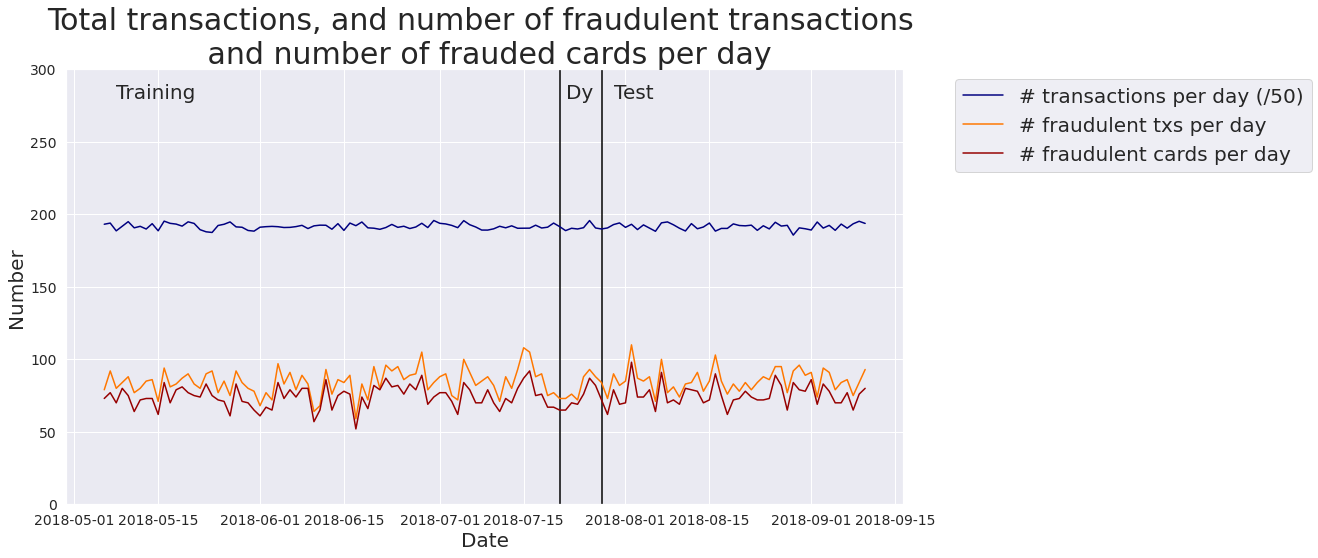

In [ ]:
fraud_and_transactions_stats_fig

The plot illustrates that the number of transactions and frauds is similar in the training and test periods. The average number of frauds is around 85 per day. Let us extract from the dataset the transactions for the training set and the test set. 

We now extract our test set and train set 

In [ ]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be frauded after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known frauded customers from the training set
    known_frauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Frauded cards from that test day, minus the delay period, are added to the pool of known frauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_frauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_frauded_customers = known_frauded_customers.union(new_frauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_frauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [ ]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train,delta_delay,delta_test)

The trainig set contains 728537 transactions, among which 6405 are fraudulent.

In [ ]:
train_df.shape

(728537, 23)

In [ ]:
train_df[train_df.TX_FRAUD==1].shape


(6405, 23)

The test set contains 158744 transactions, among which 951 are fraudulent.

In [ ]:
test_df.shape

(158744, 23)

In [ ]:
test_df[test_df.TX_FRAUD==1].shape


(951, 23)

That is, a proportion of 0.006 fraudulent transactions.

In [ ]:
951/158744

0.0059907776041929145

In [ ]:
test_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1131345,1131345,2018-07-28 00:04:06,4076,5478,87.27,10195446,118,0,0,1,1,1.0,87.270000,9.0,76.427778,31.0,69.035484,1.0,0.0,3.0,0.0,26.0,0.038462
1131347,1131347,2018-07-28 00:06:13,22,772,28.45,10195573,118,0,0,1,1,5.0,29.096000,25.0,29.933200,75.0,33.933333,1.0,0.0,1.0,0.0,25.0,0.000000
1131349,1131349,2018-07-28 00:09:07,1197,5685,78.99,10195747,118,0,0,1,1,2.0,64.155000,17.0,66.239412,75.0,68.390267,2.0,0.0,9.0,0.0,28.0,0.000000
1131350,1131350,2018-07-28 00:10:24,4736,7234,108.61,10195824,118,0,0,1,1,2.0,104.885000,19.0,57.865263,91.0,56.763516,1.0,0.0,10.0,0.0,34.0,0.000000
1131353,1131353,2018-07-28 00:12:01,3817,5544,54.97,10195921,118,0,0,1,1,4.0,74.687500,22.0,65.509091,88.0,64.829205,2.0,0.0,3.0,0.0,19.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552672,1552672,2018-09-09 23:36:50,2347,9207,24.03,13995410,161,0,0,1,0,1.0,24.030000,18.0,18.851667,76.0,16.158421,1.0,0.0,5.0,0.0,40.0,0.000000
1552678,1552678,2018-09-09 23:41:26,4436,9809,18.75,13995686,161,0,0,1,0,3.0,78.920000,26.0,76.202308,117.0,74.788889,1.0,0.0,7.0,0.0,35.0,0.028571
1552689,1552689,2018-09-09 23:47:32,303,3242,129.96,13996052,161,0,0,1,0,4.0,108.947500,12.0,84.105000,59.0,62.976441,1.0,0.0,4.0,0.0,14.0,0.000000
1552696,1552696,2018-09-09 23:51:58,4849,1437,3.43,13996318,161,0,0,1,0,3.0,47.916667,23.0,78.292609,95.0,88.832842,1.0,0.0,5.0,0.0,32.0,0.000000


## Saving train and test datasets

Let us finally save the transformed dataset, split into daily batches, using the pickle format. 

Let's start with the training set

In [ ]:
DIR_OUTPUT = "/content/drive/MyDrive/Colab Notebooks/tesi/ready for repository/train&test/train/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = start_date_training
for day in range(train_df.TX_TIME_DAYS.min(),train_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = train_df[train_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day) - datetime.timedelta(days = train_df.TX_TIME_DAYS.min())
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)



And now the test set


In [ ]:
DIR_OUTPUT = "/content/drive/MyDrive/Colab Notebooks/tesi/ready for repository/train&test/test/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = start_date_test
for day in range(test_df.TX_TIME_DAYS.min(),test_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = test_df[test_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day) - datetime.timedelta(days = test_df.TX_TIME_DAYS.min())
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)